In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#from feature_engine import missing_data_imputers as mdi
#from feature_engine import categorical_encoders as ce

from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm



# 1) Nettoyage des données :

### a) Regarder database, les variables :


In [4]:
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
with open('/Users/florinepritzy/Documents/3 projets/opioid_use_data.csv') as f:
    df = pd.read_csv(f)
f.close()
SEED = 42
df.shape
df.head(10)
df.info()
#we have 160615 observations with 92 features 

/Users/florinepritzy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 92 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ClaimID                          160616 non-null  int64  
 1   Accident DateID                  144713 non-null  float64
 2   Claim Setup DateID               160616 non-null  int64  
 3   Report To DateID                 160616 non-null  int64  
 4   Employer Notification DateID     160615 non-null  float64
 5   Benefits State                   160616 non-null  object 
 6   Accident State                   144713 non-null  object 
 7   Industry ID                      160616 non-null  int64  
 8   Claimant Age                     160616 non-null  int64  
 9   Claimant Sex                     160616 non-null  object 
 10  Claimant State                   160300 non-null  object 
 11  Claimant Marital Status          160616 non-null  object 
 12  Nu

### b) Informations manquantes : remplacer les X et "" en NaN  

#### Transforme toute l'information manquante en nan

In [54]:
for var in df.columns:
    print(var, df[var].unique(), '\n')

ClaimID [  7275  17596  13834 ... 182403 190166 182604] 

Accident DateID [33460.    nan 35043. ... 35553. 35592. 35565.] 

Claim Setup DateID [33467 34301 35054 ... 34716 34933 35003] 

Report To DateID [33462 34300 35050 ... 34241 33631 34283] 

Employer Notification DateID [33460. 34270. 35043. ... 32708. 32977. 35590.] 

Benefits State ['OK' 'CO' 'MD' 'IL' 'CA' 'GA' 'NJ' 'FL' 'WI' 'LA' 'AR' 'TX' 'AZ' 'MO'
 'NC' 'MN' 'PA' 'MI' 'NY' 'MA' 'VA' 'OH' 'RI' 'SC' 'CT' 'IA' 'AL' 'NV'
 'OR' 'HI' 'KY' 'TN' 'NE' 'IN' 'KS' 'MS' 'ME' 'LH' 'NH' 'UT' 'WA' 'DC'
 'DE' 'ID' 'NM' 'MT' 'WV' 'VT' 'SD' 'WY' 'JA' 'ND'] 

Accident State ['OK' nan 'MD' 'IL' 'CA' 'NJ' 'FL' 'WI' 'LA' 'AR' 'TX' 'AZ' 'CO' 'MO' 'MN'
 'MI' 'NY' 'MA' 'VA' 'GA' 'OH' 'RI' 'SC' 'IN' 'CT' 'IA' 'AL' 'OR' 'HI'
 '  ' 'NC' 'PA' 'NE' 'TN' 'KS' 'MS' 'KY' 'ME' 'NV' 'NH' 'ID' 'UT' 'WA'
 'DC' 'DE' 'NM' 'MT' 'WV' 'VT' 'QC' 'SD' 'WY' 'ND' 'PR' 'ON' 'AK' 'NB'
 'GU' 'AB' 'BC' 'NW' 'QU'] 

Industry ID [17  9 10  2 14 18  8 11 13  7 16 12 15  3  4  

In [5]:
# Converting nulls to np.nan
for var in df.columns:
    df[var].replace(to_replace=' ', value=np.nan, inplace=True)
    
# Converting values of "X" to np.nan
for var in df.columns:
    df[var].replace(to_replace='X', value=np.nan, inplace=True)

for var in df.columns:
    df[var].replace(to_replace='    ', value=np.nan, inplace=True)

###  c) Regarder le pourcentage de NA dans les variables : supprimer les variables avec plus de 50% de valeurs manquantes 

In [6]:
for var in df.columns:
    print(var, 'percent of missing values', df[var].isnull().mean().round(3)>0.5)
#Accident Source Code percent of missing values is true = have 50% of null

ClaimID percent of missing values False
Accident DateID percent of missing values False
Claim Setup DateID percent of missing values False
Report To DateID percent of missing values False
Employer Notification DateID percent of missing values False
Benefits State percent of missing values False
Accident State percent of missing values False
Industry ID percent of missing values False
Claimant Age percent of missing values False
Claimant Sex percent of missing values False
Claimant State percent of missing values False
Claimant Marital Status percent of missing values False
Number Dependents percent of missing values False
Weekly Wage percent of missing values False
Employment Status Flag percent of missing values False
RTW Restriction Flag percent of missing values False
Max Medical Improvement DateID percent of missing values True
Percent Impairment percent of missing values False
Post Injury Weekly Wage percent of missing values False
NCCI Job Code percent of missing values False
Sur

#### 2 variables apparaissent : "Accident Source Code" et "Max Medical Imporvement DateID"

In [7]:
df.drop('Accident Source Code', axis = 1, inplace = True)
df.drop('Max Medical Improvement DateID', axis = 1, inplace = True)

### d) Supprimer les variables qui n'apportent rien : variable ID 

In [8]:
for var in df.columns:
    print(var, df[var].nunique(), len(df))

#peut supprimer ClaimID = car c'est un ID unique pour chaque patient

ClaimID 160616 160616
Accident DateID 2508 160616
Claim Setup DateID 2396 160616
Report To DateID 2019 160616
Employer Notification DateID 2538 160616
Benefits State 52 160616
Accident State 61 160616
Industry ID 21 160616
Claimant Age 92 160616
Claimant Sex 3 160616
Claimant State 60 160616
Claimant Marital Status 4 160616
Number Dependents 16 160616
Weekly Wage 75472 160616
Employment Status Flag 12 160616
RTW Restriction Flag 2 160616
Percent Impairment 95 160616
Post Injury Weekly Wage 1355 160616
NCCI Job Code 2071 160616
Surgery Flag 2 160616
Disability Status 4 160616
SIC Group 51 160616
NCCI BINatureOfLossDescription 15 160616
Accident Type Group 16 160616
Neurology Payment Flag 2 160616
Neurosurgery Payment Flag 2 160616
Dentist Payment Flag 2 160616
Orthopedic Surgery Payment Flag 2 160616
Psychiatry Payment Flag 2 160616
Hand Surgery Payment Flag 2 160616
Optometrist Payment Flag 2 160616
Podiatry Payment Flag 2 160616
HCPCS A Codes 37 160616
HCPCS B Codes 3 160616
HCPCS C C

#### 1 variable apparait : "ClaimID"

In [9]:
df.drop ('ClaimID', axis = 1, inplace = True)

### e) Regarde la corrélation entre les variables 
#### Matrice de corrélation : afficher la corrélation entre les variables numériques

In [10]:
corr_matrix = df.corr().abs() #take absolute value of matrice correlation : want positive value 
corr_matrix

,Accident DateID,Claim Setup DateID,Report To DateID,Employer Notification DateID,Industry ID,Claimant Age,Number Dependents,Weekly Wage,Percent Impairment,Post Injury Weekly Wage,Surgery Flag,Neurology Payment Flag,Neurosurgery Payment Flag,Dentist Payment Flag,Orthopedic Surgery Payment Flag,Psychiatry Payment Flag,Hand Surgery Payment Flag,Optometrist Payment Flag,Podiatry Payment Flag,HCPCS A Codes,HCPCS B Codes,HCPCS C Codes,HCPCS D Codes,HCPCS E Codes,HCPCS F Codes,HCPCS G Codes,HCPCS H Codes,HCPCS I Codes,HCPCS J Codes,HCPCS K Codes,HCPCS L Codes,HCPCS M Codes,HCPCS N Codes,HCPCS O Codes,HCPCS P Codes,HCPCS Q Codes,HCPCS R Codes,HCPCS S Codes,HCPCS T Codes,HCPCS U Codes,HCPCS V Codes,HCPCS W Codes,HCPCS X Codes,HCPCS Y Codes,HCPCS Z Codes,ICD Group 1,ICD Group 2,ICD Group 3,ICD Group 4,ICD Group 5,ICD Group 6,ICD Group 7,ICD Group 8,ICD Group 9,ICD Group 10,ICD Group 11,ICD Group 12,ICD Group 13,ICD Group 14,ICD Group 15,ICD Group 16,ICD Group 17,ICD Group 18,ICD Group 19,ICD Group 20,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Benzo,NDC Class - Misc (Zolpidem),NDC Class - Muscle Relaxants,NDC Class - Stimulants,Opiods Used
Accident DateID,1.000000,0.992483,0.993462,0.995020,0.004154,0.010695,0.036018,0.010670,0.134289,0.049074,0.135031,0.038273,0.037529,0.019431,0.091537,0.057880,0.018759,0.004128,0.066799,0.085595,0.004589,0.010104,0.006228,0.108151,0.033867,0.030992,0.005061,0.008981,0.066734,0.016273,0.068934,0.103838,0.049762,0.018378,0.043105,0.036460,0.008612,0.034857,0.029229,0.001773,0.007001,0.094704,0.003217,0.002318,0.049492,0.039893,0.037396,0.028689,0.040333,0.071203,0.171896,0.033241,0.033784,0.066827,0.047526,0.067651,0.054951,0.315585,0.038981,0.008637,0.014260,0.039070,0.135190,0.052350,0.031032,0.186262,0.124726,0.160121,0.190538,0.106322,0.135261,0.149116,0.044144,0.052774,0.070667,0.001963,0.145555
Claim Setup DateID,0.992483,1.000000,0.999172,0.997141,0.003075,0.004492,0.041018,0.007758,0.127034,0.044831,0.136179,0.038616,0.038605,0.020792,0.096506,0.061228,0.019982,0.006546,0.069855,0.089091,0.005886,0.012562,0.003996,0.109118,0.033712,0.029270,0.005735,0.006528,0.072640,0.016624,0.076742,0.091498,0.051455,0.018336,0.043757,0.039663,0.007898,0.037829,0.016988,0.001232,0.007632,0.099099,0.000462,0.001960,0.047623,0.041074,0.040108,0.031985,0.042532,0.076875,0.177359,0.035814,0.035641,0.072057,0.051272,0.072338,0.060656,0.332064,0.041857,0.010600,0.014043,0.042083,0.144563,0.061913,0.032623,0.199341,0.130649,0.176621,0.193041,0.107506,0.140116,0.154839,0.043585,0.052496,0.073857,0.001477,0.147656
Report To DateID,0.993462,0.999172,1.000000,0.997972,0.003196,0.005053,0.040825,0.008037,0.127554,0.044856,0.135707,0.038550,0.038562,0.020794,0.096098,0.061112,0.019748,0.006329,0.069654,0.088358,0.005850,0.012360,0.003884,0.108746,0.033553,0.029431,0.005795,0.006528,0.072018,0.016496,0.075972,0.091741,0.051531,0.018322,0.043714,0.039290,0.007914,0.037552,0.017190,0.001236,0.007636,0.099280,0.000589,0.001946,0.047787,0.040998,0.040109,0.031834,0.042384,0.076908,0.177104,0.035678,0.035569,0.071881,0.051053,0.072168,0.060427,0.331684,0.041741,0.010529,0.014000,0.041984,0.144216,0.061503,0.032521,0.198877,0.130218,0.174589,0.192106,0.107225,0.139071,0.154095,0.043639,0.052403,0.073427,0.001432,0.147189
Employer Notification DateID,0.995020,0.997141,0.997972,1.000000,0.003700,0.005873,0.040124,0.008282,0.129576,0.045137,0.136051,0.038167,0.038300,0.020343,0.095763,0.060964,0.019722,0.006098,0.069111,0.086754,0.005799,0.012028,0.003462,0.108258,0.033666,0.029069,0.005694,0.007358,0.070926,0.016203,0.074218,0.093612,0.051077,0.018320,0.043691,0.038263,0.007734,0.037137,0.018760,0.001185,0.007918,0.097908,0.000971,0.001885,0.047889,0.040780,0.040103,0.031602,0.042154,0.077236,0.177495,0.035389,0.035578,0.071497,0.050753,0.072033,0.059915,0.331106,0.041405,0.010295,0.013986,0.041849,0.143

In [12]:
df.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

In [13]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

In [14]:
to_drop #On a 3 variables avec une corrélation plus grande que 0.8 dans la matrice : on doit donc les enlever de notre dataset

['Claim Setup DateID', 'Report To DateID', 'Employer Notification DateID']

#### On a 3 variables qui ont une forte colinéarité : on peut les supprimer. Regle : | rij| >0,8 donc detection de colinearité entre ces 3 variables 

In [15]:
df.drop(df[to_drop], axis=1, inplace=True) #drop 4 variables 

### f) Regarder trois variables catégorielles qui traduisent la même information 

In [16]:
states = pd.DataFrame(df[['Claimant State', 'Accident State', 'Benefits State']])
states


,Claimant State,Accident State,Benefits State
0,OK,OK,OK
1,CO,NaN,CO
2,VA,MD,MD
3,IL,IL,IL
4,WI,IL,IL
...,...,...,...
160611,PA,PA,PA
160612,PA,PA,PA
160613,PA,NaN,PA
160614,AZ,AZ,AZ


In [17]:
print(states['Claimant State'].isnull().values.sum()) #316
print(states["Accident State"].isnull().values.sum()) #15903
print(states['Benefits State'].isnull().values.sum())  #0 = garder cette variable la 

316
15903
0


#### On voit que la variable la plus complète est "Benefits State": on garde cette variable 
Garde la variable Benefits Stats = qui traduisait la même information que Claimant State et Accident State mais sans valeurs manquantes 

In [18]:
df.drop(['Claimant State', 'Accident State'], axis=1, inplace=True) 

### g) Transforme la variable Accident en un seul type : devient 2 variables, garde que la variable numérique

In [19]:
# Splitting out "Accident Type Group" (ie. mixed type feature) into separate features
df['Accident Type Group num'] = df['Accident Type Group'].str.extract('(\d+)')
df['Accident Type Group str'] = df['Accident Type Group'].str[0:5]
df.drop(['Accident Type Group'], axis=1, inplace=True)

In [20]:
df['Accident Type Group num']

0           7
1           6
2         NaN
3           6
4           1
         ... 
160611      5
160612      6
160613      1
160614      5
160615      7
Name: Accident Type Group num, Length: 160616, dtype: object

In [21]:
df.drop(['Accident Type Group str'], axis=1, inplace=True) 

### h) Traitement des missing values

####  Les différentes manières d'avoir des données manquantes  :
- Quand la valeur d’une variable explicative (feature) X est manquante, on dit que cette feature est MCAR (Missing Completly At Random) si et seulement si la probabilité que la valeur soit manquante est indépendant des valeurs prises par les autres variables explicatives de l’observation, qu’elles soient manquantes ou non = peut pas deviner l'information avec une autre variable 
- On dit que les données manquantes d’une feature X sont Missing At Random (MAR) si et seulement si, la probabilité qu’une valeur X soit manquante est corrélée à l’existence de variables explicatives dont les valeurs sont renseignées. Par contre cette probabilité n’est pas corrélée à l’absence de valeurs  de variables explicatives.
- NMAR = il existe un pattern qui motive l’absence d’une valeur = ex = les gens les plus fortunés ne veulent pas dire leurs salaires. Délicates à traiter car l’absence d’une donnée est motivée par une cause que nous avons interêt à comprendre pour mieux traiter ces données absentes.
#### Les 2 premières sont ignorables mais pas NMAR= doit comprendre pourquoi il n'y a pas l'information

#### Techniques :
- 1) supprime l'information = l'observation
- 2) remplace valeur manquante par soit règle si on a une variable qui nous aide / remplace par moyenne pour quanti et mode pour quali 
- 3) Hot Deck = choisi aléatoirement autres valeurs

In [70]:
for var in df.columns:
    if df[var].isnull().sum() > 0:
        print(var, df[var].isnull().mean()) #toutes les variables qui ont des missing values

Accident DateID 0.09901255167604722
Claimant Sex 0.0019674254121631717
Claimant Marital Status 0.0019674254121631717
Employment Status Flag 0.0021666583652936197
RTW Restriction Flag 0.22657144991781641
NCCI Job Code 1.2452059570652986e-05
Disability Status 0.1311762215470439
NCCI BINatureOfLossDescription 0.08981670568311999
Accident Type Group num 0.06542934701399611


#### On a 1 variable quantitative et 7 variables qualitatives 
- Nous avons décidé de supprimer les variables qui ont plus que 20% de NA (RTW Restriction Flag)
- Nous supprimons également la variable Accident DateID= qui correspond à une date aléatoire, inexploitable


In [71]:
df.drop(['RTW Restriction Flag','Accident DateID'], axis = 1, inplace = True)

#### NCCI Job Code : 
La NCCI est une organisation à but non lucratif financée par les compagnies d'assurance sur le marché de l'indemnisation des travailleurs. C'est une base de données qui est utilisée par les professionnels de l'assurance pour identifier les codes de classe d'indemnisation des accidents du travail associés à chaque employé en fonction des activités que les employés exercent dans le cadre de leur travail. Chaque année, il existe entre 700 et 800 codes de classification individuels. Or ces codes n'ont pas été harmonisé pour chaque état, ce qui rend la variable très complexe. En effets, elle a 5040 valeurs différentes. Elle n'apporte rien à notre database, nous avons décidé de la supprimer 

In [72]:
df.drop(['NCCI Job Code'], axis=1, inplace=True) 

#### Claimant Sex and Claimant Marital Statuts : 
Ce sont les mêmes 316 individus qui n'ont pas déclaré leur sexe, ni leur statut marital. Nous pouvons les mettre dans la catégorie "unknown". Soit ces informations n'étaient pas disponibles pour l'assurance car les individus n'ont pas voulu le dire, soit un oubli a été fait. 

In [73]:
print(df[["Claimant Sex", "Claimant Marital Status"]].isnull().sum())

Claimant Sex               316
Claimant Marital Status    316
dtype: int64


In [74]:
df_SEX = df[["Claimant Sex", "Claimant Marital Status"]].copy()

df_SEX.set_index("Claimant Marital Status").isna().sum(level=0) #ok même individus 
df_SEX.set_index("Claimant Sex").isna().sum(level=0) #ok même individus 

,Claimant Marital Status
Claimant Sex,
M,0
F,0
U,0


In [75]:
df["Claimant Sex"].fillna("U", inplace = True)

In [76]:
df["Claimant Marital Status"].fillna("U", inplace = True)

In [77]:
df["Claimant Sex"].value_counts()

M    96719
F    62699
U     1198
Name: Claimant Sex, dtype: int64

#### Employment Status Flag :
On peut voir qu'il y a seulement 348 individus qui n'ont pas répondu à cette information. C'est également les individus qui sont indiqués en unknown pour "sexe" and "marital statuts" : 317 individus

In [78]:
print(df[["Employment Status Flag"]].isnull().sum())

Employment Status Flag    348
dtype: int64


In [79]:
df= df.dropna(subset=["Employment Status Flag"], axis=0, how='any')

In [80]:
df["Claimant Sex"].value_counts()

M    96697
F    62690
U      881
Name: Claimant Sex, dtype: int64

#### Disability Status :

In [81]:
print(df[["Disability Status"]].isnull().sum())

Disability Status    21016
dtype: int64


#### NCCI BINatureOfLossDescription : 

In [82]:
print(df[["NCCI BINatureOfLossDescription"]].isnull().sum())

NCCI BINatureOfLossDescription    14378
dtype: int64


#### Accident Type Group num : 

In [83]:
print(df[["Accident Type Group num"]].isnull().sum())

Accident Type Group num    10491
dtype: int64


In [89]:
var_with_null = pd.DataFrame(df[[ "Disability Status",
                                               "NCCI BINatureOfLossDescription", "Accident Type Group num"]])


In [90]:
#imputation par le mode: les NaN sont remplacés par le mode
from sklearn.impute import SimpleImputer

imp=SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
var_with_null_cat=pd.DataFrame(imp.fit_transform(var_with_null))
var_with_null_cat.columns=var_with_null.columns
var_with_null_cat.index=var_with_null.index

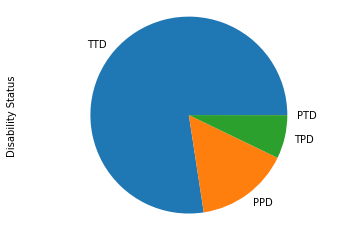

In [92]:
import matplotlib.pyplot as plt

# VARIABLE QUALITATIVE
# Diagramme en secteurs
var_with_null_cat["Disability Status"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

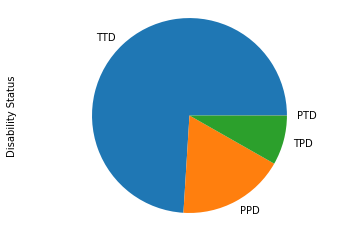

In [94]:
#Diagramme en secteurs
df["Disability Status"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

In [96]:
df[["NCCI BINatureOfLossDescription", "Accident Type Group num", "Disability Status"]]=var_with_null_cat[["NCCI BINatureOfLossDescription", "Accident Type Group num", "Disability Status"]]

### h) 84 variables : doit ranger par types puis recoder

In [97]:
categorical = ['Benefits State', 'Industry ID', 'Claimant Sex', 'Claimant Marital Status', 'Employment Status Flag', 
'Surgery Flag', 'Disability Status', 'SIC Group', 'NCCI BINatureOfLossDescription',
'Orthopedic Surgery Payment Flag','Neurology Payment Flag', 'Neurosurgery Payment Flag', 'Dentist Payment Flag',
         'Psychiatry Payment Flag', 'Hand Surgery Payment Flag', 'Optometrist Payment Flag',
         'Podiatry Payment Flag', 'Accident Type Group num']


In [98]:
len(categorical)

18

In [99]:
discrete = ['Claimant Age', 'Number Dependents', 'Percent Impairment', 'HCPCS A Codes',
'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes','HCPCS L Codes', 'HCPCS W Codes', 
'ICD Group 6', 'ICD Group 13','ICD Group 18', 'ICD Group 19', 'ICD Group 21', 
'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt', 'CPT Category - Medicine', 
'CPT Category - Path_Lab', 'CPT Category - Radiology', 'CPT Category - Surgery', 
'NDC Class - Muscle Relaxants','HCPCS B Codes','HCPCS C Codes', 'HCPCS D Codes', 'HCPCS F Codes', 'HCPCS H Codes', 'HCPCS I Codes',
'HCPCS K Codes', 'HCPCS M Codes', 'HCPCS N Codes', 'HCPCS O Codes', 'HCPCS P Codes',
'HCPCS Q Codes', 'HCPCS R Codes', 'HCPCS S Codes', 'HCPCS T Codes', 'HCPCS U Codes', 
'HCPCS V Codes', 'HCPCS X Codes', 'HCPCS Y Codes', 'HCPCS Z Codes', 'ICD Group 1',
'ICD Group 2', 'ICD Group 3', 'ICD Group 4', 'ICD Group 5', 'ICD Group 7', 'ICD Group 8', 
'ICD Group 9', 'ICD Group 10', 'ICD Group 11', 'ICD Group 12', 'ICD Group 14', 'ICD Group 15', 
'ICD Group 16', 'ICD Group 17', 'ICD Group 20', 'NDC Class - Benzo', 'NDC Class - Misc (Zolpidem)',
'NDC Class - Stimulants']

In [100]:
len(discrete)

60

In [101]:
continuous = ['Weekly Wage','Post Injury Weekly Wage' ]


In [102]:
len(continuous)

2

In [103]:
df.columns,'Number of Features:',len(df.columns)

(Index(['Benefits State', 'Industry ID', 'Claimant Age', 'Claimant Sex',
        'Claimant Marital Status', 'Number Dependents', 'Weekly Wage',
        'Employment Status Flag', 'Percent Impairment',
        'Post Injury Weekly Wage', 'Surgery Flag', 'Disability Status',
        'SIC Group', 'NCCI BINatureOfLossDescription', 'Neurology Payment Flag',
        'Neurosurgery Payment Flag', 'Dentist Payment Flag',
        'Orthopedic Surgery Payment Flag', 'Psychiatry Payment Flag',
        'Hand Surgery Payment Flag', 'Optometrist Payment Flag',
        'Podiatry Payment Flag', 'HCPCS A Codes', 'HCPCS B Codes',
        'HCPCS C Codes', 'HCPCS D Codes', 'HCPCS E Codes', 'HCPCS F Codes',
        'HCPCS G Codes', 'HCPCS H Codes', 'HCPCS I Codes', 'HCPCS J Codes',
        'HCPCS K Codes', 'HCPCS L Codes', 'HCPCS M Codes', 'HCPCS N Codes',
        'HCPCS O Codes', 'HCPCS P Codes', 'HCPCS Q Codes', 'HCPCS R Codes',
        'HCPCS S Codes', 'HCPCS T Codes', 'HCPCS U Codes', 'HCPCS V Codes',
    

##### 1) Recodage des variables de categorical 

#### SIC Group : recode puis diminue le nombre de classes: transfrom SIC 36 into SIC
- 1-9:Agriculture,Forestry,Fishing
- 10-14:Mining
- 15-17:Construction
- 20-39:Manufacturing
- 40-49:Transportation
- 50-51: Wholesale,Trade
- 52-59: Retail Trade
- 60-67: Finance, Insurance
- 70-89: Services
- 91-99: Public Administration

In [110]:
df['SIC Group'].unique()
df['SIC Group'] = df['SIC Group'].replace(['Gen. cont.', 'Misc. Manuf. Ind.', 'Misc. Services',
       'Business Services', 'Trans. Equip.', 'Ins. Agnts. Brkrs. & Ser.',
       'Real Estate', 'Nonprofit Membshp. Org.',
       'Engineering & Management Services', 'Food and Kindred Prod.',
       'Health Services', 'Rub. & Misc. Plas. Prod.',
       'Executive, Legislative, and General',
       'Elec. Elect. Mach.Equip.& Sup.', 'Other',
       'Eating & Drnkng.Places', 'Social Services', 'Trans. by Air',
       'Misc. Retail', 'Communication', 'Ins. Carriers',
       'Motor Frgt.Trns.&Wrhsng.',
       'Hotls,Rmng. Hses. Cmps.& Oth. Lodg.Plcs.',
       'Trans.Serv.Frgt.Frwdg.Etc.', 'App.& Oth.Fin.Prod.',
       'Autom. Dlrs. & Gas. Ser.Stat.', 'Trans.Serv.Frgt.FRwdg.Etc.',
       'Hldng.& Oth. Inv. Co.', 'Amusemt. & Rec. Ser.ex. Mot. Pics.',
       'Educational Services', 'Tex. Mill Prod.', 'Whlsale Trade,Non',
       'Stone,Clay,Gls.&Conc.Prod.', 'Whlsale Trade,Dur.Gds.',
       'Loc.&Subur. Trnst.& Inturb.', 'Appl. & Acces. Stores',
       'Food Stores', 'Oil & Gas Extraction', 'Commercial printing, nec',
       'Chem. & Alld. Prod.', 'Stationery products',
       'Elec. Gas, & San.Serv.', 'Mach., Ex. Elec.', 
                                           'Per. Service','Primy. Metal Ind.', 
                                           'Agricultural Production', 
                                           'Furn. & Fixt.',
                                           'Newspapers:publishing, publishing & printing',
                                           'Auto. Repr. Serv.& Gar.', 
                                           'Hardware stores', 
                                           'Banking'], ["construction","manufacturing","services",
                                                                  "services","manufacturing","finance",
                                                                  "finance","public_admi","services","manufacturing",
                                                                  "services","manufacturing","public_admi","manufacturing",
                                                                  "public_admi","retail_trade","services","transportation",
                                                                  "retail_trade","services","finance","transportation",
                                                                 "services","transportation","manufacturing","services",
                                                                  "transportation","finance","services","services",
                                                                  "manufacturing","whole_sale_trade","manufacturing",
                                                                  "whole_sale_trade","transportation","retail_trade",
                                                                  "retail_trade","mining","manufacturing","manufacturing",
                                                                  "retail_trade",
                                                                    "transportation",
                                                                    "manufacturing",
                                                                  "services",
                                                                  "manufacturing",
                                                                  "agriculture",
                                                                  "manufacturing",
                                                                  "manufacturing",
                                                                  "retail_trade",
                                                                  "retail_trade",
                                                                  "finance"])

In [111]:
df['SIC Group'].unique()

array(['construction', 'manufacturing', 'services', 'finance',
       'public_admi', 'retail_trade', 'transportation',
       'whole_sale_trade', 'mining', 'agriculture'], dtype=object)

One hot encoding for the categorical features

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160268 entries, 0 to 160615
Data columns (total 81 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Benefits State                   160268 non-null  object 
 1   Industry ID                      160268 non-null  int64  
 2   Claimant Age                     160268 non-null  int64  
 3   Claimant Sex                     160268 non-null  object 
 4   Claimant Marital Status          160268 non-null  object 
 5   Number Dependents                160268 non-null  int64  
 6   Weekly Wage                      160268 non-null  float64
 7   Employment Status Flag           160268 non-null  object 
 8   Percent Impairment               160268 non-null  int64  
 9   Post Injury Weekly Wage          160268 non-null  float64
 10  Surgery Flag                     160268 non-null  int64  
 11  Disability Status                160268 non-null  object 
 12  SI

In [131]:
df[['SIC Group','Disability Status','Claimant Sex', 'Claimant Marital Status', 'Employment Status Flag', 
'NCCI BINatureOfLossDescription','Accident Type Group num']].astype('object')


,SIC Group,Disability Status,Claimant Sex,Claimant Marital Status,Employment Status Flag,NCCI BINatureOfLossDescription,Accident Type Group num
0,construction,TTD,M,M,F,Strain,7
1,construction,PPD,M,M,F,Inflammation,6
2,construction,TTD,M,U,F,Foreign Body,6
3,manufacturing,TTD,F,M,P,Strain,6
4,manufacturing,TTD,F,M,F,Contusions,1
...,...,...,...,...,...,...,...
160611,retail_trade,TTD,M,S,F,Fractures,5
160612,services,TTD,F,M,P,Sprain,6
160613,services,TTD,M,S,F,Lacerations/Scarring,1
160614,services,TPD,F,U,P,Strain,5


In [136]:
df['Industry ID']=df['Industry ID'].astype('object')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160268 entries, 0 to 160615
Data columns (total 81 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Benefits State                   160268 non-null  object 
 1   Industry ID                      160268 non-null  object 
 2   Claimant Age                     160268 non-null  int64  
 3   Claimant Sex                     160268 non-null  object 
 4   Claimant Marital Status          160268 non-null  object 
 5   Number Dependents                160268 non-null  int64  
 6   Weekly Wage                      160268 non-null  float64
 7   Employment Status Flag           160268 non-null  object 
 8   Percent Impairment               160268 non-null  int64  
 9   Post Injury Weekly Wage          160268 non-null  float64
 10  Surgery Flag                     160268 non-null  int64  
 11  Disability Status                160268 non-null  object 
 12  SI

In [158]:
encoder = ce.OneHotCategoricalEncoder(
    top_categories=52,
    variables=['Benefits State','SIC Group','Disability Status','Claimant Sex', 'Claimant Marital Status', 'Employment Status Flag', 
'NCCI BINatureOfLossDescription','Accident Type Group num','Industry ID'],
    drop_last=False)
encoder.fit(df)
df_t= encoder.transform(df)
df=df_t
df


,Claimant Age,Number Dependents,Weekly Wage,Percent Impairment,Post Injury Weekly Wage,Surgery Flag,Neurology Payment Flag,Neurosurgery Payment Flag,Dentist Payment Flag,Orthopedic Surgery Payment Flag,Psychiatry Payment Flag,Hand Surgery Payment Flag,Optometrist Payment Flag,Podiatry Payment Flag,HCPCS A Codes,HCPCS B Codes,HCPCS C Codes,HCPCS D Codes,HCPCS E Codes,HCPCS F Codes,HCPCS G Codes,HCPCS H Codes,HCPCS I Codes,HCPCS J Codes,HCPCS K Codes,HCPCS L Codes,HCPCS M Codes,HCPCS N Codes,HCPCS O Codes,HCPCS P Codes,HCPCS Q Codes,HCPCS R Codes,HCPCS S Codes,HCPCS T Codes,HCPCS U Codes,HCPCS V Codes,HCPCS W Codes,HCPCS X Codes,HCPCS Y Codes,HCPCS Z Codes,ICD Group 1,ICD Group 2,ICD Group 3,ICD Group 4,ICD Group 5,ICD Group 6,ICD Group 7,ICD Group 8,ICD Group 9,ICD Group 10,ICD Group 11,ICD Group 12,ICD Group 13,ICD Group 14,ICD Group 15,ICD Group 16,ICD Group 17,ICD Group 18,ICD Group 19,ICD Group 20,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Benzo,NDC Class - Misc (Zolpidem),NDC Class - Muscle Relaxants,NDC Class - Stimulants,Opiods Used,Benefits State_CA,Benefits State_IL,Benefits State_FL,Benefits State_NY,Benefits State_TX,Benefits State_PA,Benefits State_CT,Benefits State_NJ,Benefits State_MO,Benefits State_WI,Benefits State_GA,Benefits State_MN,Benefits State_NC,Benefits State_MA,Benefits State_MD,Benefits State_MI,Benefits State_IN,Benefits State_SC,Benefits State_CO,Benefits State_TN,Benefits State_OK,Benefits State_OR,Benefits State_VA,Benefits State_AZ,Benefits State_OH,Benefits State_WA,Benefits State_KY,Benefits State_IA,Benefits State_AL,Benefits State_LA,Benefits State_NV,Benefits State_KS,Benefits State_MS,Benefits State_HI,Benefits State_RI,Benefits State_NE,Benefits State_UT,Benefits State_DC,Benefits State_AR,Benefits State_WV,Benefits State_NM,Benefits State_ID,Benefits State_NH,Benefits State_DE,Benefits State_ME,Benefits State_MT,Benefits State_LH,Benefits State_SD,Benefits State_VT,Benefits State_WY,Benefits State_JA,Benefits State_ND,SIC Group_services,SIC Group_retail_trade,SIC Group_transportation,SIC Group_manufacturing,SIC Group_public_admi,SIC Group_finance,SIC Group_whole_sale_trade,SIC Group_agriculture,SIC Group_construction,SIC Group_mining,Disability Status_TTD,Disability Status_PPD,Disability Status_TPD,Disability Status_PTD,Claimant Sex_M,Claimant Sex_F,Claimant Sex_U,Claimant Marital Status_S,Claimant Marital Status_M,Claimant Marital Status_U,Claimant Marital Status_P,Employment Status Flag_F,Employment Status Flag_P,Employment Status Flag_L,Employment Status Flag_A,Employment Status Flag_O,Employment Status Flag_R,Employment Status Flag_V,Employment Status Flag_U,Employment Status Flag_S,Employment Status Flag_B,Employment Status Flag_C,Employment Status Flag_D,NCCI BINatureOfLossDescription_Strain,NCCI BINatureOfLossDescription_Other,NCCI BINatureOfLossDescription_Contusions,NCCI BINatureOfLossDescription_Fractures,NCCI BINatureOfLossDescription_Sprain,NCCI BINatureOfLossDescription_Lacerations/Scarring,NCCI BINatureOfLossDescription_Inflammation,NCCI BINatureOfLossDescription_Dislocation,NCCI BINatureOfLossDescription_Death,NCCI BINatureOfLossDescription_Burns,NCCI BINatureOfLossDescription_Crushing,NCCI BINatureOfLossDescription_Puncture,NCCI BINatureOfLossDescription_No Physical Injury,NCCI BINatureOfLossDescription_Skin,NCCI BINatureOfLossDescription_Foreign Body,Accident Type Group num_6,Accident Type Group num_5,Accident Type Group num_1,Accident Type Group num_7,Accident Type Group num_2,Accident Type Group num_8,Accident Type Group num_4,Accident Type Group num_9,Accident Type Group num_3,Accident Type Group num_10,Accident Type Group num_11,Accident Type Group num_12,Accident Type Group num_15,Accident Type Group num_14,Accident Type Group num_13,Accident Type Group num_16,Industry ID_14,Industry ID_13,Industry ID_16,Industry ID_10,Industry ID_7,Industr

In [159]:
df['Orthopedic Surgery Payment Flag'] = df['Orthopedic Surgery Payment Flag'].replace([True, False], [1, 0])
df['Neurology Payment Flag'] = df['Neurology Payment Flag'].replace([True, False], [1, 0])
df['Neurosurgery Payment Flag'] = df['Neurosurgery Payment Flag'].replace([True, False], [1, 0])
df['Dentist Payment Flag'] = df['Dentist Payment Flag'].replace([True, False], [1, 0])
df['Psychiatry Payment Flag'] = df['Psychiatry Payment Flag'].replace([True, False], [1, 0])
df['Hand Surgery Payment Flag'] = df['Hand Surgery Payment Flag'].replace([True, False], [1, 0])
df['Optometrist Payment Flag'] = df['Optometrist Payment Flag'].replace([True, False], [1, 0])
df['Podiatry Payment Flag'] = df['Podiatry Payment Flag'].replace([True, False], [1, 0])

In [160]:
df['Opiods Used']= df['Opiods Used'].replace([True,False], [1,0])

In [161]:
df

,Claimant Age,Number Dependents,Weekly Wage,Percent Impairment,Post Injury Weekly Wage,Surgery Flag,Neurology Payment Flag,Neurosurgery Payment Flag,Dentist Payment Flag,Orthopedic Surgery Payment Flag,Psychiatry Payment Flag,Hand Surgery Payment Flag,Optometrist Payment Flag,Podiatry Payment Flag,HCPCS A Codes,HCPCS B Codes,HCPCS C Codes,HCPCS D Codes,HCPCS E Codes,HCPCS F Codes,HCPCS G Codes,HCPCS H Codes,HCPCS I Codes,HCPCS J Codes,HCPCS K Codes,HCPCS L Codes,HCPCS M Codes,HCPCS N Codes,HCPCS O Codes,HCPCS P Codes,HCPCS Q Codes,HCPCS R Codes,HCPCS S Codes,HCPCS T Codes,HCPCS U Codes,HCPCS V Codes,HCPCS W Codes,HCPCS X Codes,HCPCS Y Codes,HCPCS Z Codes,ICD Group 1,ICD Group 2,ICD Group 3,ICD Group 4,ICD Group 5,ICD Group 6,ICD Group 7,ICD Group 8,ICD Group 9,ICD Group 10,ICD Group 11,ICD Group 12,ICD Group 13,ICD Group 14,ICD Group 15,ICD Group 16,ICD Group 17,ICD Group 18,ICD Group 19,ICD Group 20,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Benzo,NDC Class - Misc (Zolpidem),NDC Class - Muscle Relaxants,NDC Class - Stimulants,Opiods Used,Benefits State_CA,Benefits State_IL,Benefits State_FL,Benefits State_NY,Benefits State_TX,Benefits State_PA,Benefits State_CT,Benefits State_NJ,Benefits State_MO,Benefits State_WI,Benefits State_GA,Benefits State_MN,Benefits State_NC,Benefits State_MA,Benefits State_MD,Benefits State_MI,Benefits State_IN,Benefits State_SC,Benefits State_CO,Benefits State_TN,Benefits State_OK,Benefits State_OR,Benefits State_VA,Benefits State_AZ,Benefits State_OH,Benefits State_WA,Benefits State_KY,Benefits State_IA,Benefits State_AL,Benefits State_LA,Benefits State_NV,Benefits State_KS,Benefits State_MS,Benefits State_HI,Benefits State_RI,Benefits State_NE,Benefits State_UT,Benefits State_DC,Benefits State_AR,Benefits State_WV,Benefits State_NM,Benefits State_ID,Benefits State_NH,Benefits State_DE,Benefits State_ME,Benefits State_MT,Benefits State_LH,Benefits State_SD,Benefits State_VT,Benefits State_WY,Benefits State_JA,Benefits State_ND,SIC Group_services,SIC Group_retail_trade,SIC Group_transportation,SIC Group_manufacturing,SIC Group_public_admi,SIC Group_finance,SIC Group_whole_sale_trade,SIC Group_agriculture,SIC Group_construction,SIC Group_mining,Disability Status_TTD,Disability Status_PPD,Disability Status_TPD,Disability Status_PTD,Claimant Sex_M,Claimant Sex_F,Claimant Sex_U,Claimant Marital Status_S,Claimant Marital Status_M,Claimant Marital Status_U,Claimant Marital Status_P,Employment Status Flag_F,Employment Status Flag_P,Employment Status Flag_L,Employment Status Flag_A,Employment Status Flag_O,Employment Status Flag_R,Employment Status Flag_V,Employment Status Flag_U,Employment Status Flag_S,Employment Status Flag_B,Employment Status Flag_C,Employment Status Flag_D,NCCI BINatureOfLossDescription_Strain,NCCI BINatureOfLossDescription_Other,NCCI BINatureOfLossDescription_Contusions,NCCI BINatureOfLossDescription_Fractures,NCCI BINatureOfLossDescription_Sprain,NCCI BINatureOfLossDescription_Lacerations/Scarring,NCCI BINatureOfLossDescription_Inflammation,NCCI BINatureOfLossDescription_Dislocation,NCCI BINatureOfLossDescription_Death,NCCI BINatureOfLossDescription_Burns,NCCI BINatureOfLossDescription_Crushing,NCCI BINatureOfLossDescription_Puncture,NCCI BINatureOfLossDescription_No Physical Injury,NCCI BINatureOfLossDescription_Skin,NCCI BINatureOfLossDescription_Foreign Body,Accident Type Group num_6,Accident Type Group num_5,Accident Type Group num_1,Accident Type Group num_7,Accident Type Group num_2,Accident Type Group num_8,Accident Type Group num_4,Accident Type Group num_9,Accident Type Group num_3,Accident Type Group num_10,Accident Type Group num_11,Accident Type Group num_12,Accident Type Group num_15,Accident Type Group num_14,Accident Type Group num_13,Accident Type Group num_16,Industry ID_14,Industry ID_13,Industry ID_16,Industry ID_10,Industry ID_7,Industr

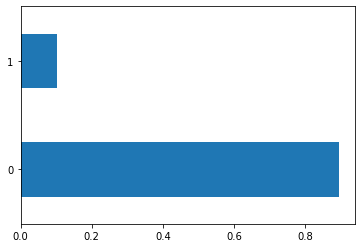

In [162]:
(df['Opiods Used'].value_counts()/len(df)).plot(kind='barh')

In [166]:
df.to_csv(r'C:/csv')